# Data Cleaning

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
# Configuration for prompt extraction
config = {
    'min_words': 5,
    'max_words': 500,
    'min_chars': 20,
    'max_chars': 3000,
    'min_unique_ratio': 0.3,
    'exclude_patterns': [
        r'^[\s\W]*$',
        r'^(yes|no|ok|thanks|thank you|hi|hello|bye|goodbye)$',
        r'^[0-9\s\W]*$',
        r'^.{1,10}$'
    ]
}

def clean_text(text):
    if not isinstance(text, str):
        return None
    text = re.sub(r'\s+', ' ', text.strip())
    return text if len(text) > 0 else None

def validate_prompt(text, config):
    if not text:
        return False
    if len(text) < config['min_chars'] or len(text) > config['max_chars']:
        return False
    
    words = text.split()
    if len(words) < config['min_words'] or len(words) > config['max_words']:
        return False
    
    unique_ratio = len(set(word.lower() for word in words)) / len(words)
    if unique_ratio < config['min_unique_ratio']:
        return False
    
    for pattern in config['exclude_patterns']:
        if re.match(pattern, text, re.IGNORECASE):
            return False
    
    return True


In [5]:
# Process conversations file directly without loading into memory
import json

def process_conversations_file():
    prompts = []
    
    with open('data/conversations.jsonl', 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f):
            if line.strip():
                try:
                    conversation_data = json.loads(line)
                    if conversation_data.get('language', '').lower() == 'english':
                        conversation = conversation_data.get('conversation', [])
                        for message in conversation:
                            if message.get('role') == 'user' and 'content' in message:
                                cleaned_text = clean_text(message['content'])
                                if cleaned_text and validate_prompt(cleaned_text, config):
                                    prompts.append({
                                        'prompt_text': cleaned_text,
                                        'processed': 0
                                    })
                except json.JSONDecodeError:
                    continue
    
    return prompts

# Process file and create dataframe
prompts = process_conversations_file()
prompts_df = pd.DataFrame(prompts)


In [6]:
# Save prompts to JSONL file
output_path = Path('data/prompts.jsonl')
output_path.parent.mkdir(parents=True, exist_ok=True)
prompts_df.to_json(output_path, orient='records', lines=True)


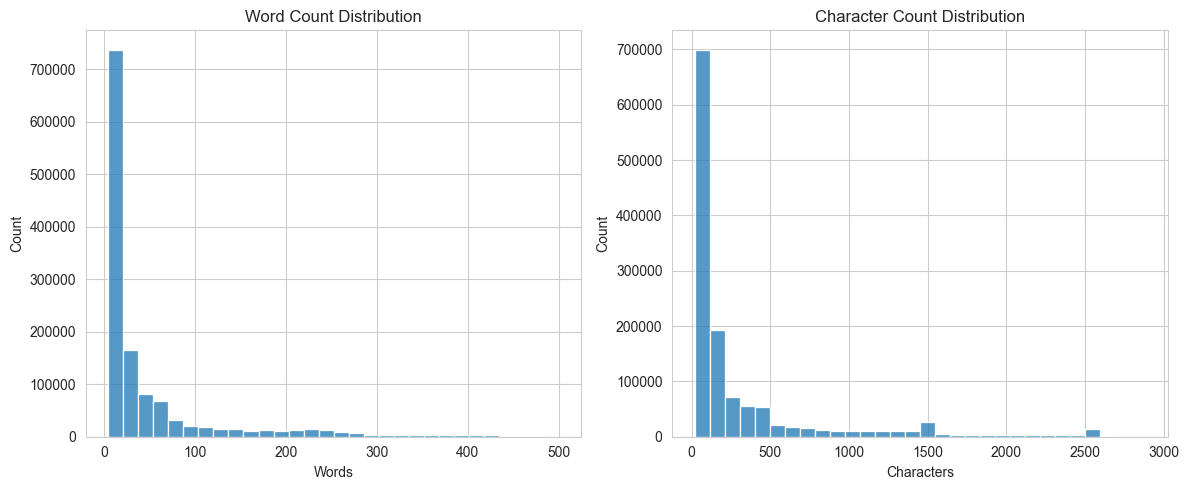

In [7]:
# Create visualizations with seaborn
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Word count distribution
word_counts = [len(prompt.split()) for prompt in prompts_df['prompt_text']]
sns.histplot(word_counts, bins=30, ax=axes[0])
axes[0].set_title('Word Count Distribution')
axes[0].set_xlabel('Words')

# Character count distribution  
char_counts = [len(prompt) for prompt in prompts_df['prompt_text']]
sns.histplot(char_counts, bins=30, ax=axes[1])
axes[1].set_title('Character Count Distribution')
axes[1].set_xlabel('Characters')

plt.tight_layout()
plt.show()
